In [ ]:
! pip install -q tensorflow numpy pandas scikit-learn mlxtend
! cp drive/My\ Drive/Colab\ Notebooks/*.csv ./

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf 
from datetime import date
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [ ]:
def build_model():
  model = tf.keras.Sequential([tf.keras.layers.Dense(1024, 
                                                     name='dense_1',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dropout(rate=0.8),
                               tf.keras.layers.Dense(2048, 
                                                     name='dense_2',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dropout(rate=0.5),
                               tf.keras.layers.Dense(1024, 
                                                     name='dense_3',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dropout(rate=0.8),
                               tf.keras.layers.Dense(1, name='output',
                                                     activation=tf.keras.activations.sigmoid)])
  print(model.compute_output_shape(input_shape=(None, 2204)))
  model.build(input_shape=(None, 2204))
  return model

In [ ]:
def ds_from_df(df, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Meme')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
df = pd.read_csv('dankmemes_task1_train.csv')
embedding = pd.read_csv('dankmemes_task1_train_embeddings.csv', header=None)
X, y = np.array([embedding[1][i].split() for i in range(1600)]).astype(float), df[['Meme']].values

In [ ]:
ssc = StandardScaler()
mms = MinMaxScaler()
ohe = OneHotEncoder()

In [ ]:
temp = mms.fit_transform(np.array([(date(int(i[0].split('-')[0]), int(i[0].split('-')[1]), int(i[0].split('-')[2])) - date(2015, 1, 1)).days for i in df[['Date']].values.tolist()]).reshape(1600, 1))
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = ssc.fit_transform(df[['Engagement']].values)
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = ohe.fit_transform(df[['Visual']].values.reshape(-1, 1)).toarray().astype(float)
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = df[['Manipulation']].values
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

(1600, 1)
(1600, 2049)
(1600, 1)
(1600, 2050)
(1600, 153)
(1600, 2203)
(1600, 1)
(1600, 2204)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_valid = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
print(ds_train)
print(ds_valid)

<TensorSliceDataset shapes: ((2204,), (1,)), types: (tf.float64, tf.int64)>
<TensorSliceDataset shapes: ((2204,), (1,)), types: (tf.float64, tf.int64)>


In [ ]:
print(X)

[[0.21587265 0.72570091 0.16331738 ... 0.         0.         1.        ]
 [0.12842497 0.61847848 0.16297877 ... 0.         0.         0.        ]
 [0.50468701 2.17241144 1.70308435 ... 0.         0.         0.        ]
 ...
 [0.5379979  0.91525936 1.05429924 ... 0.         0.         0.        ]
 [0.14643477 2.55643654 0.83304083 ... 0.         0.         0.        ]
 [0.55178326 0.71752226 0.77621841 ... 0.         0.         0.        ]]


In [ ]:
buffer_size = 10000
batch_size = 64
num_epochs = 100

In [ ]:
ds_train = ds_train.shuffle(buffer_size=buffer_size,
                            reshuffle_each_iteration=False)

In [ ]:
ds_valid = ds_valid.batch(batch_size)
ds_train = ds_train.batch(batch_size)

In [ ]:
model = build_model()
model.build(input_shape=(None, 2204))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

(None, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  2257920   
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2099200   
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2098176   
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
output (Dense)               multiple       

In [ ]:
hist = model.fit(ds_train,
                 validation_data=(ds_valid),
                 epochs=num_epochs,
                 batch_size=batch_size)

Epoch 1/100
20/20 [==============================] - 1s 37ms/step - loss: 0.4328 - binary_accuracy: 0.8031 - val_loss: 0.5597 - val_binary_accuracy: 0.7250
Epoch 2/100
20/20 [==============================] - 1s 37ms/step - loss: 0.4306 - binary_accuracy: 0.8016 - val_loss: 0.5409 - val_binary_accuracy: 0.7563
Epoch 3/100
20/20 [==============================] - 1s 37ms/step - loss: 0.4195 - binary_accuracy: 0.8203 - val_loss: 0.5389 - val_binary_accuracy: 0.7594
Epoch 4/100
20/20 [==============================] - 1s 37ms/step - loss: 0.3960 - binary_accuracy: 0.8328 - val_loss: 0.5310 - val_binary_accuracy: 0.7625
Epoch 5/100
20/20 [==============================] - 1s 38ms/step - loss: 0.3859 - binary_accuracy: 0.8352 - val_loss: 0.5457 - val_binary_accuracy: 0.7437
Epoch 6/100
20/20 [==============================] - 1s 37ms/step - loss: 0.3799 - binary_accuracy: 0.8273 - val_loss: 0.5159 - val_binary_accuracy: 0.7656
Epoch 7/100
20/20 [==============================] - 1s 37ms/ste

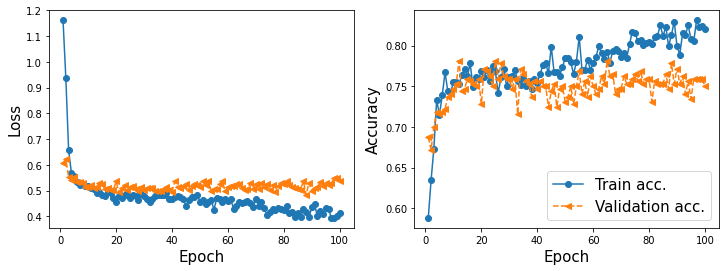

In [ ]:
history = hist.history
x_arr = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history['loss'], '-o', label='Train loss')
ax.plot(x_arr, history['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, history['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()